<a href="https://colab.research.google.com/github/jakebentley2001/Modelling/blob/main/CaliforniaHousingLinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders

In [ ]:
pip install geopandas

In [ ]:
pip install rtree

In [ ]:
pip install pygeos

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import matplotlib.colors as cl
from shapely.geometry import Point
import rtree
import pygeos


In [ ]:
pip install mapclassify

In [32]:
import mapclassify

In [3]:
from google.colab import files
 #Here since we are using Google colab we need to upload the file so we can read it
 
uploaded = files.upload()

Saving housing.csv to housing.csv


In [37]:
data = pd.read_csv('housing.csv')
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
datagpd = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
)
datagpd

In [ ]:
states_gdf = gpd.read_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json")
states_gdf = states_gdf[['geometry', 'NAME']] 
states_gdf = states_gdf.loc[(states_gdf.NAME == "California")]
states_gdf.head()

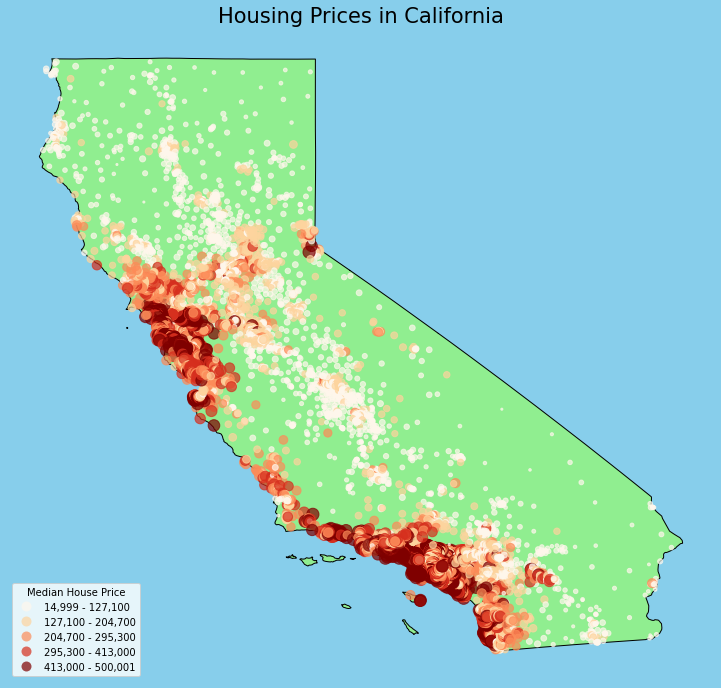

In [36]:
fig, ax = plt.subplots(figsize=(16,12))
fig.patch.set_facecolor('skyblue')

ax.set_title('Housing Prices in California', fontsize=21)
ax.set_axis_off()

#USA continent boundary
states_gdf.plot(
    ax=ax,
    color='lightgreen', 
    edgecolor='black',
    categorical=False
)
#Plotting capacity_mw 
datagpd.plot(
    ax=ax,
    column='median_house_value',
    categorical=True,
    cmap='OrRd',
    alpha=0.7,
    scheme='fisher_jenks',
    k=5,
    legend=True,
    markersize= datagpd['median_house_value'] * 0.0003,
    legend_kwds={'loc': 'lower left'}
)

#Creating legend
leg = ax.get_legend()
leg.set_title('Median House Price')
for t in leg.get_texts():
  ranges = t.get_text().split(',')
  label = '{:,.0f} - {:,.0f}'.format(float(ranges[0].strip()), float(ranges[1].strip()))
  t.set_text(label)

plt.show()

In [ ]:
ce_be = ce.BinaryEncoder(cols=['ocean_proximity'])

data1 = ce_be.fit_transform(data)
data1.head()
data1 = data1.dropna()


In [ ]:
print(data1.isna().sum().sum())

0


In [ ]:
#Here we are constructing the appropriate matrices
b = data1.loc[:,"median_house_value"]
A = data1.iloc[:,[0,1,2,3,4,5,6,7,9,10,11]]
#A = data1.iloc[:,[0,1,2,3,4,5,6,7]]
#A = data1.iloc[:,[0,3,4,5,6,7]]


In [ ]:
x = [1] * 20433
A.insert(0, "Pad", x, True)
A.head()

,Pad,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_0,ocean_proximity_1,ocean_proximity_2
0,1,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1
2,1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1
3,1,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1
4,1,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1


In [ ]:
A = A.to_numpy()
b = b.to_numpy()


In [ ]:
x = [len(b),len(A)]
x

[20433, 20433]

In [ ]:
n = 1000
p = np.random.permutation(20433)
Ap = A[p,:]
bp = b[p]
btrain = bp[1:n]
Atrain = Ap[1:n]


In [ ]:
print(np.sum(np.isnan(Atrain)))

0


In [ ]:
btest = bp[1000:1100]
Atest = Ap[1000:1100]

In [ ]:
#Solve Ax = b using SVD
U, S, VT = np.linalg.svd(Atrain,full_matrices = 0)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ btrain

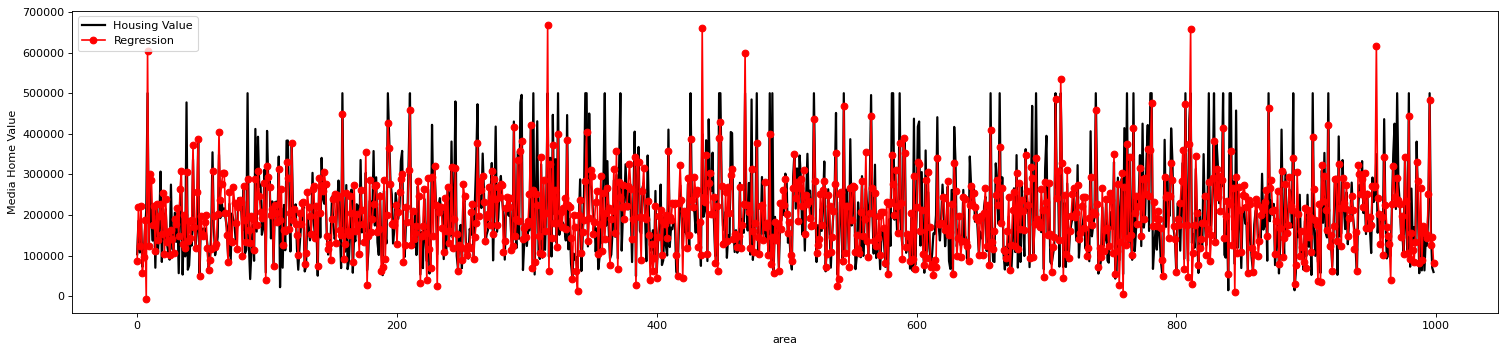

In [ ]:

figure(figsize=(23, 5), dpi=80)
#ax1 = fig.add_subplot(122)

plt.plot(btrain, Color = 'k', LineWidth = 2, label = 'Housing Value')
plt.plot(Atrain@x, '-o', Color = 'r', LineWidth = 1.5, MarkerSize = 6, label = "Regression") 
plt.xlabel('area')
plt.ylabel('Media Home Value')
plt.legend()



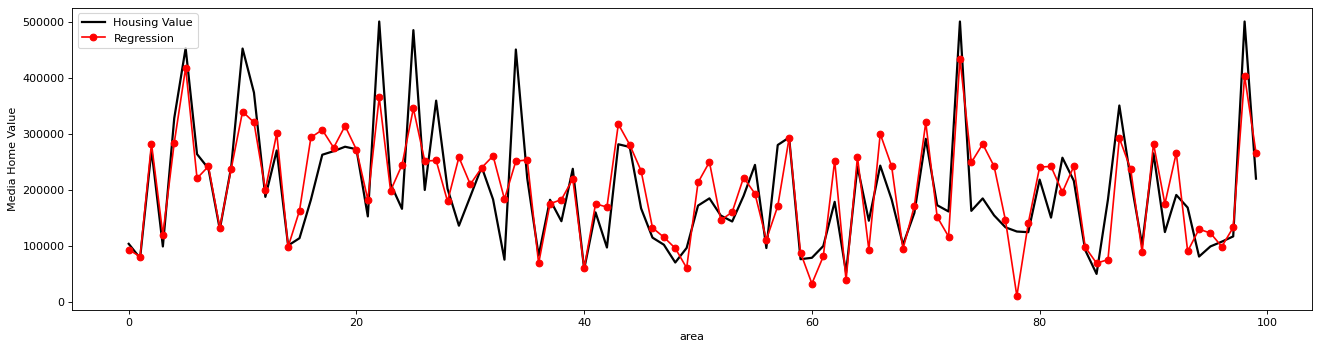

In [ ]:
#ax2 = fig.add_subplot(122)
figure(figsize=(20, 5), dpi=80)
plt.plot(btest, Color = 'k', LineWidth = 2, label = 'Housing Value')
plt.plot(Atest@x, '-o', Color = 'r', LineWidth = 1.5, MarkerSize = 6, label = "Regression") 
plt.xlabel('area')
plt.ylabel('Media Home Value')
plt.legend()

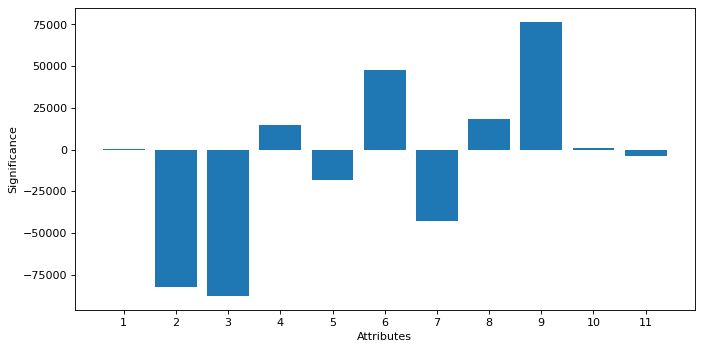

In [ ]:
A_mean = np.mean(A,axis=0)
A_mean = A_mean.reshape(-1,1)

A2 = A - np.ones((A.shape[0],1)) @ A_mean.T

for j in range(0,A.shape[1]-2):
  A2std = np.std(A2[:,j])
  if A2std == 0:
    A2std = 0.5
  A2[:,j] = A2[:,j]/(A2std)

A2[5,0] = 50

A2[:,-1] = np.ones(A.shape[0])

U, S, VT = np.linalg.svd(A2, full_matrices = 0)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b
x_tick = range(len(x)-1) + np.ones(len(x)-1)
figure(figsize=(10, 5), dpi=80)
plt.bar(x_tick,x[:-1])
plt.xlabel('Attributes')
plt.ylabel('Significance')
plt.xticks(x_tick)
plt.show()